In [1]:
import re
import pandas as pd
import spacy
from typing import List
from math import sqrt, ceil
# gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
# progress bars
from tqdm import tqdm
tqdm.pandas()

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [2]:
def read_data(filepath: str) -> pd.DataFrame:
    "Read in a tab-separated file with date, headline and news content"
    df = pd.read_csv(filepath, sep='\t', header=None,
                     names=['date', 'headline', 'content'])
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
    return df

In [3]:
df = read_data("../data/nytimes.tsv")
df.head()

,date,headline,content
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...


### Clean the input text
We clean the text from each article's content to only contain relevant alphanumeric strings (symbols do not add any value to topic modelling).

In [4]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    return df

In [5]:
df_clean = clean_data(df)

#### (Optional) Subset the dataframe for testing
Test on a subset of the full data for quicker results.

In [6]:
df1 = df_clean.iloc[:2000, :].copy()
# df1 = df_clean.copy()

### Preprocess text for topic modelling

In [7]:
def lemmatize(text: str, sentencizer: spacy.lang,
              stopwords: List[str]) -> List[str]:
    "Perform lemmatization and stopword removal in the clean text"
    doc = sentencizer(text)
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords]
    return lemma_list


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    "Preprocess text in each row of the DataFrame"
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    stopwords = nlp.Defaults.stop_words  # Default spaCy stopword list
    df['lemmas'] = df['clean'].progress_apply(lambda row: lemmatize(row, nlp, stopwords))
    return df.drop('clean', axis=1)

In [8]:
df_preproc = preprocess(df1)
df_preproc.head(3)

100%|██████████| 2000/2000 [00:56<00:00, 35.34it/s]


,date,headline,content,lemmas
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitching, keep, mets, afloat, half, ..."
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, blasio, counsel, chief, legal, a..."
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, morning, hour, labor, day, year, group..."


### Build LDA Topic Model

#### Multicore LDA algorithm

In [9]:
# Choose number of workers for multicore LDA as (num_physical_cores - 1)
def run_lda_multicore(text_df, num_topics, iterations=200, epochs=20, workers=7):
    id2word = corpora.Dictionary(text_df['lemmas'])
    # Filter out words that occur in less than 2% documents or more than 50% of the documents.
    id2word.filter_extremes(no_below=0.02, no_above=0.5)
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    # LDA Model
    lda_model = LdaMulticore(
       corpus=corpus,
       id2word=id2word,
       workers=workers,
       num_topics=num_topics,
       random_state=1,
       chunksize=2048,
       passes=epochs,
       iterations=iterations,
    )
    return lda_model, corpus

### Wordclouds of most likely words in each topic

In [10]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      colormap='cividis',
                     )
    # Define the size of the subplot matrix as a function of num_topics
    dim = ceil(sqrt(len(topics)))
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(len(topics)):
        print("Topic {}".format(i+1))
        ax = fig.add_subplot(dim, dim, i+1) 
        topic_words = dict(topics[i][1])
        wordcloud = cloud.generate_from_frequencies(topic_words)
        ax.imshow(wordcloud)
        ax.set_title('Topic {}'.format(i+1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.margins(x=0, y=0);
    plt.tight_layout();

### Run topic model and plot wordclouds

In [11]:
num_topics = 10
iterations = 200
epochs=20

model, corpus = run_lda_multicore(df_preproc, num_topics=num_topics, iterations=iterations, epochs=epochs)

Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9
Topic 10


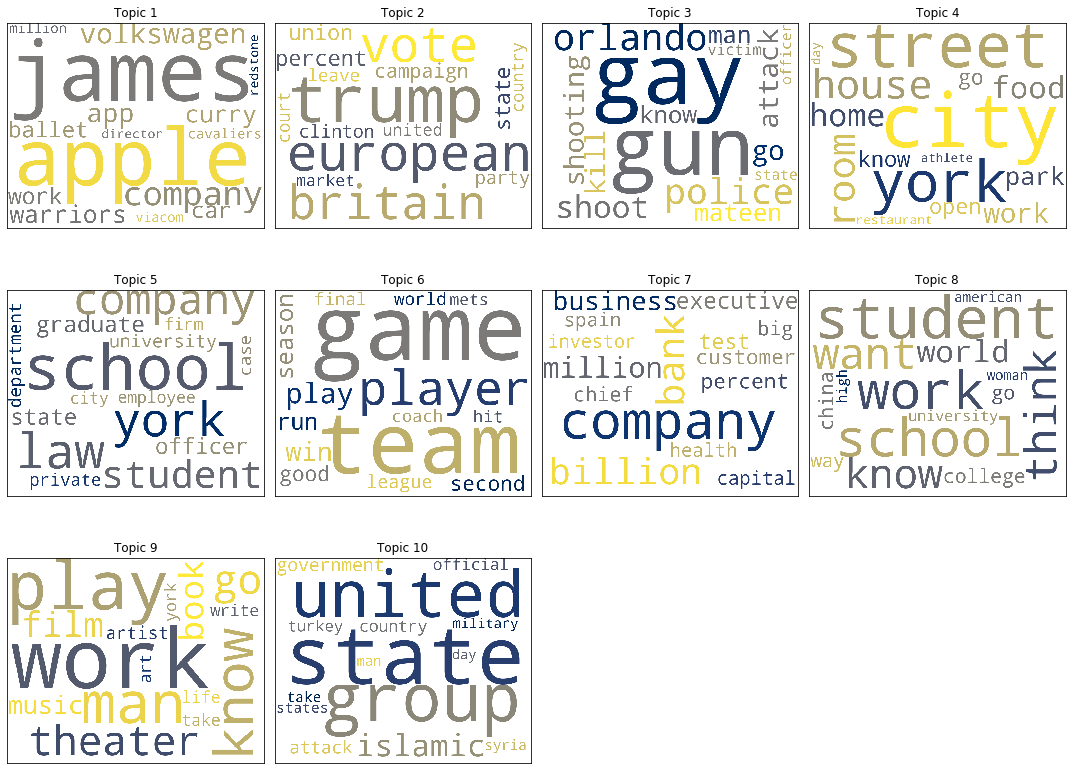

In [12]:
plot_wordclouds(model.show_topics(formatted=False, num_topics=num_topics, num_words=15))